##  Detroit Blidht Ticket Compliance

#### Goal
   - Predict whether a blight ticket will be paid on time.

### Steps
 1. Data loading
 2. Exploratory Data Analysis
 3. Baseline model
 4. Evaluation 

<div style="page-break before: always;"></div>

###  1. Import, data loading + Merge

In [1]:

import numpy as np   
import pandas as pd 
import matplotlib.pyplot as plt  

from sklearn.preprocessing import OneHotEncoder, StandardScaler 
from sklearn.compose import ColumnTransformer 
from sklearn.pipeline import Pipeline 
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_curve, roc_auc_score, classification_report

In [2]:
addresses = pd.read_csv(
    "/Users/User/Desktop/PYTHONPRO/DATA_SCIENCE_KURZUS_4_blokk/notebooks/project_hazi/addresses.csv")
addresses.head()

,ticket_id,address
0,22056,"2900 tyler, Detroit MI"
1,27586,"4311 central, Detroit MI"
2,22062,"1449 longfellow, Detroit MI"
3,22084,"1441 longfellow, Detroit MI"
4,22093,"2449 churchill, Detroit MI"


In [3]:
latlons = pd.read_csv(
    "/Users/User/Desktop/PYTHONPRO/DATA_SCIENCE_KURZUS_4_blokk/notebooks/project_hazi/latlons.csv")
latlons.head()

,address,lat,lon
0,"4300 rosa parks blvd, Detroit MI 48208",42.346169,-83.079962
1,"14512 sussex, Detroit MI",42.394657,-83.194265
2,"3456 garland, Detroit MI",42.373779,-82.986228
3,"5787 wayburn, Detroit MI",42.403342,-82.957805
4,"5766 haverhill, Detroit MI",42.407255,-82.946295


In [4]:
train = pd.read_csv(
    "/Users/User/Desktop/PYTHONPRO/DATA_SCIENCE_KURZUS_4_blokk/notebooks/project_hazi/train.csv")

C:\Users\User\AppData\Local\Temp\ipykernel_36392\3855574826.py:1: DtypeWarning: Columns (11,12,31) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv(


<div style="page-brak-before: always;"></div>

<div style="page-brak-before: always;"></div>

In [ ]:
#========================================================================
# train.csv file vilation_street_number transformation original 2900.0 -> new 2900
#========================================================================

train['violation_street_number'] = (
    train['violation_street_number'] 
    .astype(str)
    .apply(lambda x: str(int(float(x))) if x.replace('.', '').isdigit() else "")
)
train.head()

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,clean_up_cost,judgment_amount,payment_amount,balance_due,payment_date,payment_status,collection_status,grafitti_status,compliance_detail,compliance
0,22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",2900,TYLER,NaN,3.0,S. WICKER,CHICAGO,...,0.0,305.0,0.0,305.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0
1,27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311,CENTRAL,NaN,2959.0,Martin Luther King,Detroit,...,0.0,855.0,780.0,75.0,2005-06-02 00:00:00,PAID IN FULL,NaN,NaN,compliant by late payment within 1 month,1.0
2,22062,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","SANDERS, DERRON",1449,LONGFELLOW,NaN,23658.0,P.O. BOX,DETROIT,...,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN
3,22084,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","MOROSI, MIKE",1441,LONGFELLOW,NaN,5.0,ST. CLAIR,DETROIT,...,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN
4,22093,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","NATHANIEL, NEAL",2449,CHURCHILL,NaN,7449.0,CHURCHILL,DETROIT,...,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN


In [ ]:
#========================================================================
# train.csv file vilation_street_name lowercase and concatenate
#========================================================================

train['violation_street_name'] = train['violation_street_name'].str.lower().str.strip()

train['address'] = (
    train['violation_street_number'].astype(str) + ' ' +
    train['violation_street_name'].astype(str) + ', Detroit MI'
)

train.head()

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,judgment_amount,payment_amount,balance_due,payment_date,payment_status,collection_status,grafitti_status,compliance_detail,compliance,address
0,22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",2900,tyler,NaN,3.0,S. WICKER,CHICAGO,...,305.0,0.0,305.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0,"2900 tyler, Detroit MI"
1,27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311,central,NaN,2959.0,Martin Luther King,Detroit,...,855.0,780.0,75.0,2005-06-02 00:00:00,PAID IN FULL,NaN,NaN,compliant by late payment within 1 month,1.0,"4311 central, Detroit MI"
2,22062,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","SANDERS, DERRON",1449,longfellow,NaN,23658.0,P.O. BOX,DETROIT,...,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN,"1449 longfellow, Detroit MI"
3,22084,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","MOROSI, MIKE",1441,longfellow,NaN,5.0,ST. CLAIR,DETROIT,...,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN,"1441 longfellow, Detroit MI"
4,22093,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","NATHANIEL, NEAL",2449,churchill,NaN,7449.0,CHURCHILL,DETROIT,...,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN,"2449 churchill, Detroit MI"


In [ ]:
#========================================================================
# train.csv és latlons.csv merge
#========================================================================

df = train.merge(latlons, on='address', how='left')
df.head()

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,balance_due,payment_date,payment_status,collection_status,grafitti_status,compliance_detail,compliance,address,lat,lon
0,22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",2900,tyler,NaN,3.0,S. WICKER,CHICAGO,...,305.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0,"2900 tyler, Detroit MI",42.390729,-83.124268
1,27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311,central,NaN,2959.0,Martin Luther King,Detroit,...,75.0,2005-06-02 00:00:00,PAID IN FULL,NaN,NaN,compliant by late payment within 1 month,1.0,"4311 central, Detroit MI",42.326937,-83.135118
2,22062,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","SANDERS, DERRON",1449,longfellow,NaN,23658.0,P.O. BOX,DETROIT,...,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN,"1449 longfellow, Detroit MI",42.380516,-83.096069
3,22084,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","MOROSI, MIKE",1441,longfellow,NaN,5.0,ST. CLAIR,DETROIT,...,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN,"1441 longfellow, Detroit MI",42.380570,-83.095919
4,22093,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","NATHANIEL, NEAL",2449,churchill,NaN,7449.0,CHURCHILL,DETROIT,...,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN,"2449 churchill, Detroit MI",42.145257,-83.208233


================================================================================================================================

#### 2. EDA + missing values analysis

In [11]:
df.isnull().sum()

ticket_id                          0
agency_name                        0
inspector_name                     0
violator_name                     34
violation_street_number            0
violation_street_name              0
violation_zip_code            250306
mailing_address_str_number      3602
mailing_address_str_name           4
city                               0
state                             93
zip_code                           1
non_us_str_code               250303
country                            0
ticket_issued_date                 0
hearing_date                   12491
violation_code                     0
violation_description              0
disposition                        0
fine_amount                        1
admin_fee                          0
state_fee                          0
late_fee                           0
discount_amount                    0
clean_up_cost                      0
judgment_amount                    0
payment_amount                     0
b

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250306 entries, 0 to 250305
Data columns (total 37 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   ticket_id                   250306 non-null  int64  
 1   agency_name                 250306 non-null  object 
 2   inspector_name              250306 non-null  object 
 3   violator_name               250272 non-null  object 
 4   violation_street_number     250306 non-null  object 
 5   violation_street_name       250306 non-null  object 
 6   violation_zip_code          0 non-null       float64
 7   mailing_address_str_number  246704 non-null  float64
 8   mailing_address_str_name    250302 non-null  object 
 9   city                        250306 non-null  object 
 10  state                       250213 non-null  object 
 11  zip_code                    250305 non-null  object 
 12  non_us_str_code             3 non-null       object 
 13  country       

In [ ]:
#========================================================================
# Features Nan values summary
#========================================================================

df.isna().sum().sort_values(ascending=False) 

violation_zip_code            250306
grafitti_status               250305
non_us_str_code               250303
collection_status             213409
payment_date                  209193
compliance                     90426
hearing_date                   12491
mailing_address_str_number      3602
state                             93
violator_name                     34
mailing_address_str_name           4
lon                                3
lat                                3
fine_amount                        1
zip_code                           1
agency_name                        0
ticket_id                          0
violation_street_number            0
inspector_name                     0
city                               0
violation_street_name              0
admin_fee                          0
disposition                        0
violation_description              0
violation_code                     0
country                            0
ticket_issued_date                 0
d

=====================================================================================================================

-------------------------------------------------------------------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------

===============================================================================================================================

In [10]:
#========================================================================
# Leakage és irreleváns oszlopok (jellemzők) eldobása
#========================================================================

leak_cols = [
    'payment_date',
    'payment_amount',
    'payment_status',      
    'balance_due',
    'compliance_detail'  
]

df = df.drop(columns=leak_cols, errors='ignore')

drop_cols = [
    'violation_zip_code',
    'grafitti_status',
    'non_us_str_code',      
    'collection_status'  
]

df = df.drop(columns=drop_cols)
df.head()

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,mailing_address_str_number,mailing_address_str_name,city,state,...,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,compliance,address,lat,lon
0,22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",2900,tyler,3.0,S. WICKER,CHICAGO,IL,...,20.0,10.0,25.0,0.0,0.0,305.0,0.0,"2900 tyler, Detroit MI",42.390729,-83.124268
1,27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311,central,2959.0,Martin Luther King,Detroit,MI,...,20.0,10.0,75.0,0.0,0.0,855.0,1.0,"4311 central, Detroit MI",42.326937,-83.135118
2,22062,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","SANDERS, DERRON",1449,longfellow,23658.0,P.O. BOX,DETROIT,MI,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,"1449 longfellow, Detroit MI",42.380516,-83.096069
3,22084,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","MOROSI, MIKE",1441,longfellow,5.0,ST. CLAIR,DETROIT,MI,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,"1441 longfellow, Detroit MI",42.380570,-83.095919
4,22093,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","NATHANIEL, NEAL",2449,churchill,7449.0,CHURCHILL,DETROIT,MI,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,"2449 churchill, Detroit MI",42.145257,-83.208233


In [11]:
df.isnull().sum()

ticket_id                         0
agency_name                       0
inspector_name                    0
violator_name                    34
violation_street_number           0
violation_street_name             0
mailing_address_str_number     3602
mailing_address_str_name          4
city                              0
state                            93
zip_code                          1
country                           0
ticket_issued_date                0
hearing_date                  12491
violation_code                    0
violation_description             0
disposition                       0
fine_amount                       1
admin_fee                         0
state_fee                         0
late_fee                          0
discount_amount                   0
clean_up_cost                     0
judgment_amount                   0
compliance                    90426
address                           0
lat                               3
lon                         

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250306 entries, 0 to 250305
Data columns (total 28 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   ticket_id                   250306 non-null  int64  
 1   agency_name                 250306 non-null  object 
 2   inspector_name              250306 non-null  object 
 3   violator_name               250272 non-null  object 
 4   violation_street_number     250306 non-null  object 
 5   violation_street_name       250306 non-null  object 
 6   mailing_address_str_number  246704 non-null  float64
 7   mailing_address_str_name    250302 non-null  object 
 8   city                        250306 non-null  object 
 9   state                       250213 non-null  object 
 10  zip_code                    250305 non-null  object 
 11  country                     250306 non-null  object 
 12  ticket_issued_date          250306 non-null  object 
 13  hearing_date  

================================================================================================================================

<div style="page-break-before: always;"></div>


###  3. Feature enigineering

In [ ]:
#========================================================================
# Target creation
#========================================================================


df = df[df['compliance'].isin([0,1])].copy()
df['target'] = df['compliance']
df.drop(columns=['compliance'], inplace=True)

In [ ]:
#========================================================================
# Datums transformation
# #========================================================================


df['ticket_issued_date'] = pd.to_datetime(df['ticket_issued_date'])
df['hearing_date'] = pd.to_datetime(df['hearing_date'], errors='coerce')

df['days_until_hearing'] = (
    df['hearing_date'] - df['ticket_issued_date']
).dt.days.fillna(-1)

df['issue_year'] = df['ticket_issued_date'].dt.year
df['issue_month'] = df['ticket_issued_date'].dt.month
df['issue_dow'] = df['ticket_issued_date'].dt.dayofweek

In [ ]:
#========================================================================
# Log-transzformation  
#========================================================================

money_cols = ['fine_amount', 'admin_fee', 'state_fee', 'late_fee', 'judgment_amount']
for c in money_cols:
    if c in df.columns:
        df[f"log_{c}"] = np.log1p(df[c].fillna(0))

In [ ]:
#========================================================================
# Address / geo feature engineering
#========================================================================

# lat (latitude) column checking, if it there are coordinates  ->1 otherwise ->0
df['has_latlon'] = df['lat'].notna().astype(int)

df['prior_tickets_by_address'] = df.groupby( 
    ['violation_street_name', 'violation_street_number']   
)['ticket_id'].transform('count')


df['prior_tickets_by_violator'] = df.groupby(
    'violator_name'
)['ticket_id'].transform('count')

In [ ]:
#========================================================================
# Feature list
#========================================================================

numeric_feats = [
    'days_until_hearing', 'prior_tickets_by_address',
    'prior_tickets_by_violator', 'has_latlon'
] + [f"log_{c}" for c in money_cols if f"log_{c}" in df.columns]

cat_feats = [
    'violation_code', 'violation_description',
    'disposition', 'agency_name', 'city', 'state'
]

===========================================================================================================================================================

<div style="page-break-before: always;"></div>

### 4. Baseline Model - Preprocessing & Logistic Regression

In [18]:
numeric_transformer = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
])

categorical_transformer = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ('num', numeric_transformer, numeric_feats),
    ('cat', categorical_transformer, cat_feats)
])

============================================================================================================================================================

<div style="page-break-before: always;"></div>

### 5. Vizualization

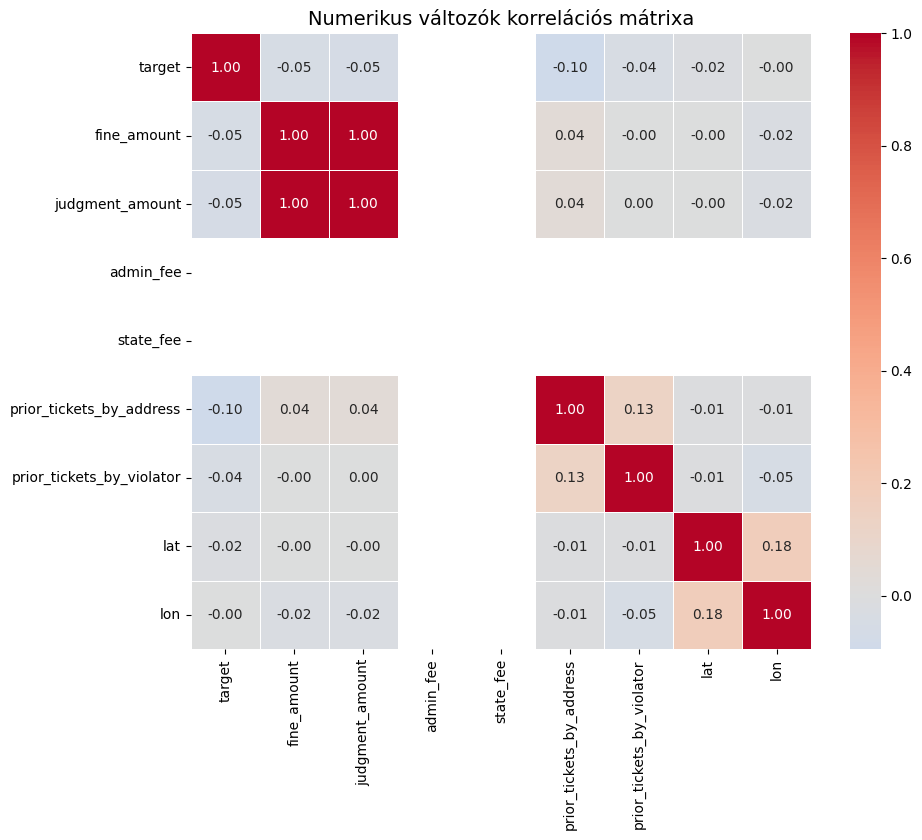

In [19]:
#========================================================================
# Korrelációs mátrix
#========================================================================

import seaborn as sns 

num_for_corr = [
    'target',
    'fine_amount',
    'judgment_amount',
    'admin_fee',
    'state_fee',
    'prior_tickets_by_address',
    'prior_tickets_by_violator',
    'lat',
    'lon'
]

corr = df[num_for_corr].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt='.2f', linewidths=0.5)
plt.title('Numerikus változók korrelációs mátrixa', fontsize=14)
plt.show()

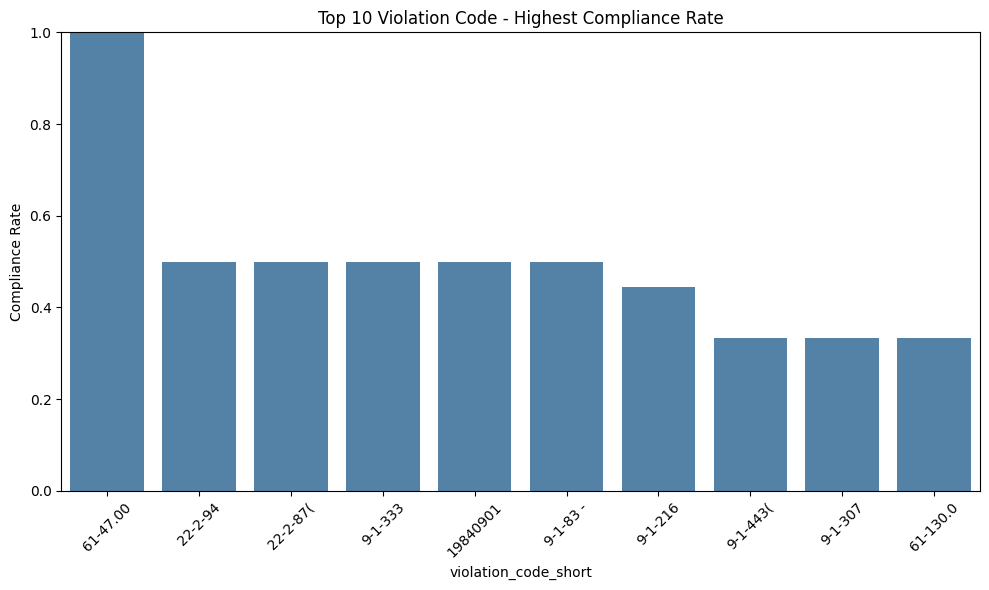

In [20]:
#========================================================================
# Pivot tábla
#  - violation_code TOP10
#  - compliance_rate átlaggal
#========================================================================
vc_compliance = (
        df.groupby('violation_code')['target']
        .mean()
        .reset_index(name='compliance_rate')
        .sort_values(by= 'compliance_rate', ascending=False)
)

data = vc_compliance.head(10).copy()

# Rövidített címkék
data['violation_code_short'] = data['violation_code'].str[:8]

plt.figure(figsize=(10,6))
sns.barplot(
        data = data,
        x = 'violation_code_short',
        y = 'compliance_rate',
        color ='steelblue'
)

plt.title('Top 10 Violation Code - Highest Compliance Rate')
plt.ylabel('Compliance Rate')
plt.xticks(rotation=45)
plt.ylim(0, 1) 
plt.tight_layout()
plt.show()

<div style="page-break-before: always;"></div>

In [21]:
# Több numerikus feature aggregálása violation code szerint
pca_features = df.groupby('violation_code').agg({
    'target': 'mean',
    'fine_amount': 'mean',
    'judgment_amount': 'mean',
    'admin_fee': 'mean',
    'state_fee': 'mean'
}) 

# Hiányzó értékek kitöltése
pca_features = pca_features.fillna(pca_features.mean())
pca_features.head()

,target,fine_amount,judgment_amount,admin_fee,state_fee
violation_code,,,,,
19420901,0.250000,475.000000,549.375000,20.0,10.0
19450901,0.027778,309.753086,369.950617,20.0,10.0
19830901,0.000000,47.500000,82.000000,20.0,10.0
19840901,0.500000,25.000000,57.500000,20.0,10.0
19850901,0.000000,50.000000,85.000000,20.0,10.0


In [ ]:
#========================================================================
#  Scaler before PCA
#========================================================================

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled = scaler.fit_transform(pca_features)

In [24]:
#========================================================================
# PCA futtatása
#========================================================================

from sklearn.decomposition import PCA

# Csak 2 komponens kell a vizualizációhoz
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled)

# Hozzáadjuk az eredményt a dataframe-hez
pca_features['PC1'] = pca_result[:,0]
pca_features['PC2'] = pca_result[:,1]

pca_features.head()

,target,fine_amount,judgment_amount,admin_fee,state_fee,PC1,PC2
violation_code,,,,,,,
19420901,0.250000,475.000000,549.375000,20.0,10.0,0.267544,1.327232
19450901,0.027778,309.753086,369.950617,20.0,10.0,-0.064850,-0.376539
19830901,0.000000,47.500000,82.000000,20.0,10.0,-0.496860,-0.574262
19840901,0.500000,25.000000,57.500000,20.0,10.0,-0.382449,3.283952
19850901,0.000000,50.000000,85.000000,20.0,10.0,-0.492634,-0.574428


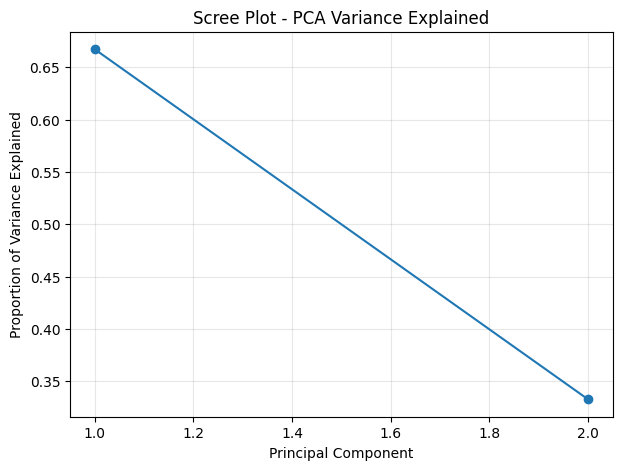

In [33]:
import matplotlib.pyplot as plt  

plt.figure(figsize=(7, 5))
plt.plot(
    range(1, len(pca.explained_variance_ratio_)+1),
    pca.explained_variance_ratio_,
    marker='o'
)
plt.title('Scree Plot - PCA Variance Explained')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.grid(alpha=0.3)
plt.show()

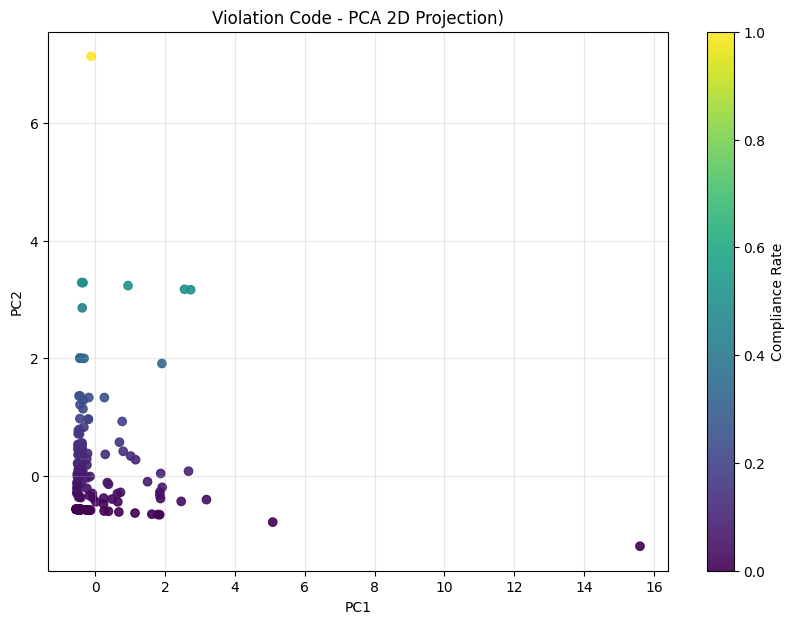

In [34]:
plt.figure(figsize=(10, 7))

plt.scatter(
    pca_features['PC1'],
    pca_features['PC2'],
    c=pca_features["target"],
    cmap='viridis',
    alpha=0.9 
)

plt.title('Violation Code - PCA 2D Projection)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Compliance Rate')
plt.grid(alpha=0.3)
plt.show()

===============================================================================================================================================================

<div style="page-break-before: always;"></div>

### 6. Modells

In [27]:
#========================================================================
# Függvény a modell betanításhoz
# Train model on train/test split and return:
#  - probabilities indexed by ticket_id
#  - AUC score
#========================================================================
from sklearn.model_selection import train_test_split 


def train_and_predict(df, model):
    X = df.drop(columns=['target'])
    y = df['target']
    
    # ticket_id külön kezelése visszaadás miatt
    ticket_ids = X['ticket_id'].copy()
    X = X.drop(columns=['ticket_id'])
    
    X_train, X_test, y_train, y_test, id_train, id_test = train_test_split(
    X, y, ticket_ids,
    test_size=0.2, random_state=42, stratify=y
    )
    
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)[:,1]
    
    pred_series = pd.Series(y_pred_proba, index=id_test, name='probability')
    
    auc = roc_auc_score(y_test, y_pred_proba)
    
    print(f"Model AUC: {auc:.4f}")
    
    return pred_series, auc, y_test
    
    


In [28]:
#========================================================================
# Modell1: Logistic Regression (baseline)
#========================================================================


from sklearn.linear_model import LogisticRegression

model_lr = Pipeline([
    ('prep', preprocess),
    ('clf', LogisticRegression(max_iter=200))
])

pred_lr, auc_lr, y_test_lr = train_and_predict(df, model_lr)
pred_lr.head()

Model AUC: 0.8139


ticket_id
138138    0.035212
149161    0.022452
57262     0.357084
30505     0.061585
192339    0.013783
Name: probability, dtype: float64

In [30]:
#========================================================================
# Modell 2: RandomForest
#========================================================================

from sklearn.ensemble import RandomForestClassifier  

model_rf = Pipeline([
    ("prep", preprocess),
    ('clf', RandomForestClassifier(
        n_estimators=100, 
        random_state=42, 
        max_depth=15))
])

pred_rf, auc_rf, y_test_rf = train_and_predict(df, model_rf)
pred_rf.head()


Model AUC: 0.8171


ticket_id
138138    0.046453
149161    0.046118
57262     0.203390
30505     0.066659
192339    0.035467
Name: probability, dtype: float64

In [31]:
#========================================================================
# Modell 3: GradientBoostingClassifier
#========================================================================


from sklearn.ensemble import GradientBoostingClassifier  

model_gb = Pipeline([
    ("prep", preprocess),
    ('clf', GradientBoostingClassifier())
])

pred_gb, auc_gb, y_test_gb = train_and_predict(df, model_gb)
pred_rf.head()


Model AUC: 0.8314


ticket_id
138138    0.046453
149161    0.046118
57262     0.203390
30505     0.066659
192339    0.035467
Name: probability, dtype: float64

#### Interpretation

Gradient Boosting achived the highest ROC-AUC score,
indicating better ranking performance compared to Logistic Regression
and Random Forest.

Given the class imbalence, RO-AUC is a more appropriate metric than accuracy.

========================================================================================================================

<div style="page-break-before: always;"></div>

### 7. Evaluation

In [33]:
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'Gradient Boosting'],
    'ROC AUC': [auc_lr, auc_rf, auc_gb]
})

results.style.background_gradient(cmap='Blues').format({'AUC': '{:.4f}'}) 

,Model,ROC AUC
0,Logistic Regression,0.813936
1,Random Forest,0.817129
2,Gradient Boosting,0.831400


In [34]:
import matplotlib.pyplot as plt  

def plot_roc_curve(y_true, y_pred_proba, model_name='Model'):
    fpr, tpr, tresholds = roc_curve(y_true, y_pred_proba)
    auc = roc_auc_score(y_true, y_pred_proba)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{model_name} AUC = {auc:.4f}')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Random baseline')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

Model AUC: 0.8139


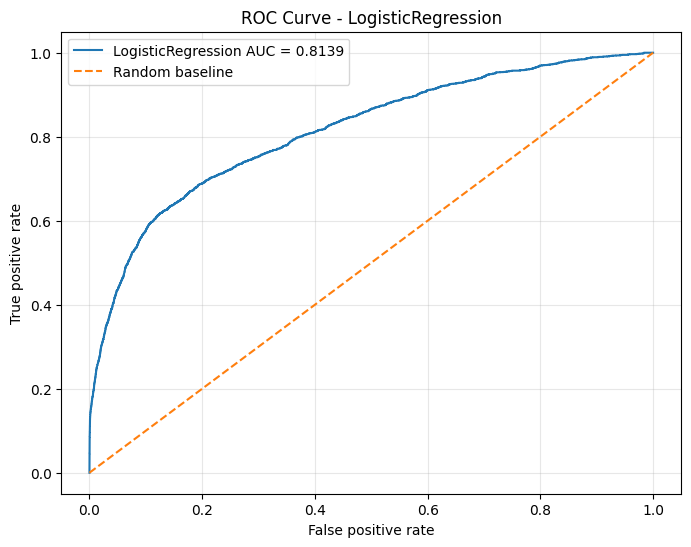

In [35]:
pred_lr, auc_lr, y_test_lr =train_and_predict(df, model_lr)

plot_roc_curve(y_test_lr, pred_lr.values, "LogisticRegression")

#### Classification reports for Logistic Regression:

In [36]:
def print_classification_report(y_test, probas, threshold=0.5):
    y_pred = (probas >= threshold).astype(int)
    print("Classification report for Logistic Regression:\n")
    print(classification_report(y_test, y_pred))

print_classification_report(y_test_lr, pred_lr.values)

Classification report for Logistic Regression:

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97     29657
         1.0       0.82      0.15      0.26      2319

    accuracy                           0.94     31976
   macro avg       0.88      0.58      0.61     31976
weighted avg       0.93      0.94      0.92     31976



Model AUC: 0.8171


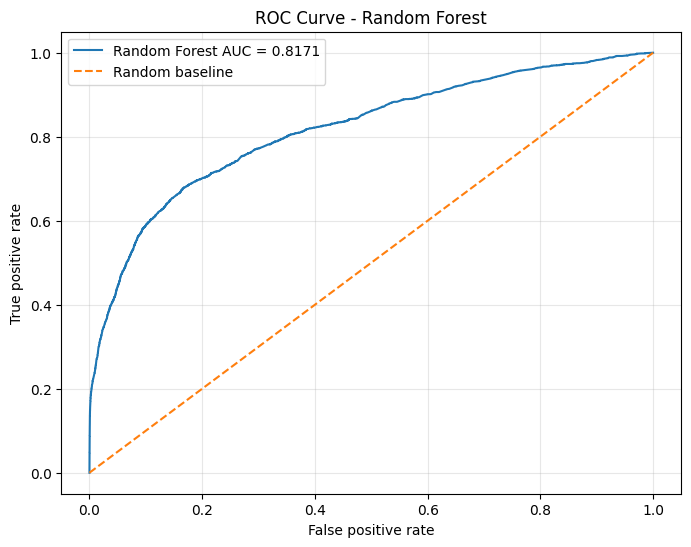

In [37]:
pred_rf, auc_rf, y_test_rf =train_and_predict(df, model_rf)

plot_roc_curve(y_test_rf, pred_rf.values, "Random Forest")


#### Classification reports for Random Forest:

In [38]:
def print_classification_report(y_test, probas, threshold=0.5):
    y_pred = (probas >= threshold).astype(int)
    print("Classification report for Random Forest:\n")
    print(classification_report(y_test, y_pred))
    
print_classification_report(y_test_rf, pred_rf.values)

Classification report for Random Forest:

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96     29657
         1.0       1.00      0.00      0.01      2319

    accuracy                           0.93     31976
   macro avg       0.96      0.50      0.49     31976
weighted avg       0.93      0.93      0.89     31976



Model AUC: 0.8314


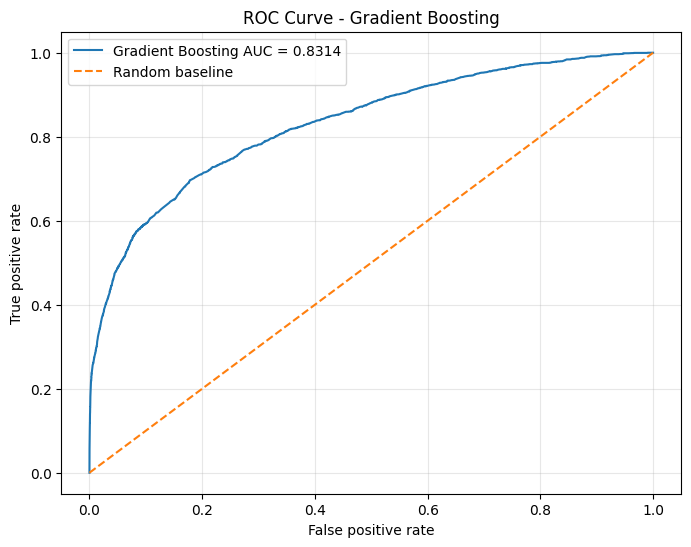

In [39]:
pred_gb, auc_gb, y_test_gb =train_and_predict(df, model_gb)

plot_roc_curve(y_test_gb, pred_gb.values, "Gradient Boosting")

#### Classification reports for Gradient Boosting:

In [40]:
def print_classification_report(y_test, probas, threshold=0.5):
    y_pred = (probas >= threshold).astype(int)
    print("Classification report for Gradient Boosting:\n")
    print(classification_report(y_test, y_pred))
    
print_classification_report(y_test_gb, pred_gb.values)

Classification report for Gradient Boosting:

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97     29657
         1.0       0.84      0.22      0.35      2319

    accuracy                           0.94     31976
   macro avg       0.89      0.61      0.66     31976
weighted avg       0.94      0.94      0.92     31976



<div style="page-break-before: always;"></div>

===================================================================================================